In [63]:
# Here we look at the Vix data set: A market index that tracks volatility in the market
# From what I infer, high Vix prices indicate high volatility in the marketplace
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from datetime import datetime
from sklearn.preprocessing import StandardScaler

In [20]:
# We do our initial tests with Bitcoin. We can expand this analysis later

coin_df = pd.read_csv('Data/coin_Bitcoin.csv')

coin_df.index = pd.to_datetime(coin_df['Date']).dt.date
coin_df.index = pd.DatetimeIndex(coin_df.index)

# Not useful
coin_df.drop('Date', axis=1, inplace=True)
coin_df.drop('SNo', axis=1, inplace=True)

coin_df.head()

,Name,Symbol,High,Low,Open,Close,Volume,Marketcap
Date,,,,,,,,
2021-02-23,Bitcoin,BTC,54204.929756,45290.590268,54204.929756,48824.426869,1.061025e+11,9.099259e+11
2021-02-24,Bitcoin,BTC,51290.136695,47213.498162,48835.087661,49705.333316,6.369552e+10,9.263931e+11
2021-02-25,Bitcoin,BTC,51948.966982,47093.853019,49709.082425,47093.853019,5.450657e+10,8.777661e+11
2021-02-26,Bitcoin,BTC,48370.785260,44454.842114,47180.464054,46339.760083,3.509679e+11,8.637523e+11
2021-02-27,Bitcoin,BTC,48253.270101,45269.025766,46344.772237,46188.451275,4.591095e+10,8.609781e+11


In [21]:
# Next we read in the Vix dataset

new_column_names = {
    'DATE': 'Date',
    'OPEN': 'Open',
    'HIGH': 'High',
    'LOW': 'Low',
    'CLOSE': 'Close'
}

vix_df = pd.read_csv('index_data/VIX_History.csv')

vix_df.rename(columns=new_column_names, inplace=True)

vix_df.index = pd.to_datetime(vix_df['Date']).dt.date
vix_df.index = pd.DatetimeIndex(vix_df.index)

vix_df.drop('Date', axis=1, inplace=True)

vix_df.head()

In [32]:
# Clearly, we can see we have data in Vix we will not need (since Bitcoin did not exist in 1990)
# Similarly, we should restrict both datasets to the time range they share
oldest_coin_date = coin_df.index.min()
oldest_vix_date = vix_df.index.min()
newest_coin_date  = coin_df.index.max()
newest_vix_date = vix_df.index.max()
print("Oldest date for Coin DF:", oldest_coin_date)
print("Most recent date for Coin DF:", newest_coin_date)
print()
print("Oldest date for Vix DF:", oldest_vix_date)
print("Most recent date for Vix DF:", newest_vix_date)

oldest_shared = max(oldest_coin_date, oldest_vix_date)
newest_shared = min(newest_coin_date, newest_vix_date)

print()
print("Oldest date shared:", oldest_shared)
print("Most recent date shared:", newest_shared)

Oldest date for Coin DF: 2013-04-29 00:00:00
Most recent date for Coin DF: 2021-02-27 00:00:00

Oldest date for Vix DF: 1990-01-02 00:00:00
Most recent date for Vix DF: 2021-03-26 00:00:00

Oldest date shared: 2013-04-29 00:00:00
Most recent date shared: 2021-02-27 00:00:00


In [34]:
vix_df = vix_df.loc[oldest_shared:newest_shared]
coin_df = coin_df.loc[oldest_shared:newest_shared]

In [99]:
# Now we have our data ready to go. 
# Let's take a subset of coin_df and calculate the "return" of each day
coin_return = pd.DataFrame(index=coin_df.index)
coin_return['coin_return'] = coin_df['Close'].pct_change()

vix_df_copy = vix_df.copy()
# Then drop the first row of both coin_return and vix_df_copy to get rid of NaN and preserve length
vix_df_copy.drop(vix_df.index[0], inplace=True)
coin_return.drop(coin_return.index[0], inplace=True)

# Then we need to drop the rows for dates not in both data sets
coin_dates = set(coin_return.index)
vix_dates = set(vix_df_copy.index)



for date in vix_dates.difference(coin_dates):
    vix_df_copy.drop(date, inplace=True)
for date in coin_dates.difference(vix_dates):
    coin_return.drop(date, inplace=True)

1969
2861


In [62]:
vix_df_copy.head()

,Open,High,Low,Close
Date,,,,
2013-04-30,13.71,14.28,13.51,13.52
2013-05-01,13.88,14.67,13.87,14.49
2013-05-02,14.48,14.48,13.58,13.59
2013-05-03,12.92,13.15,12.77,12.85
2013-05-06,13.06,13.19,12.66,12.66


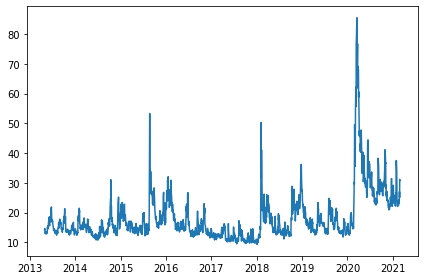

In [66]:
# A basic visualization of what the Vix data set looks like. Notice the spikes in volatility
plt.plot(vix_df_copy.index, vix_df_copy['High'])
plt.tight_layout()
plt.show()

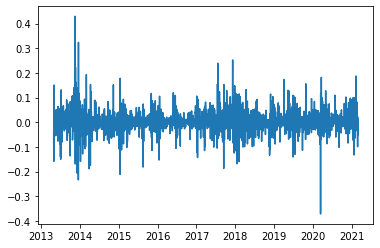

In [82]:
# A basic visualization of the coin percent return
plt.plot(coin_return.index, coin_return['coin_return'])


ValueError: x and y must have same first dimension, but have shapes (1969,) and (2861,)

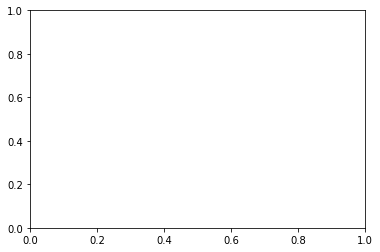

In [83]:
# Now let's try volatility vs coin return
plt.plot(vix_df_copy['High'], coin_return['coin_return'])